In [210]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


## Load and Explore Data

In [211]:
pd.set_option('display.max_columns', None)  

df = pd.read_csv('data/dataset.csv')
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


There are too many generes in our dataset, we're only interested in the most popular generes, so we looked for the top 20 genres with the highest average popularity 

In [212]:
music_features = df[['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'track_genre']]
mean_features = music_features.groupby('track_genre').mean()

# sort by popularity and display results
for genre in mean_features.sort_values('popularity', ascending=False).index[0:20]: #ascending=False for most popular
    print(genre)
df = df[(df['track_genre'].isin(mean_features.sort_values('popularity', ascending=True).index[0:10])) | (df['track_genre'].isin(mean_features.sort_values('popularity', ascending=False).index[0:10]))]


pop-film
k-pop
chill
sad
grunge
indian
anime
emo
sertanejo
pop
progressive-house
piano
mandopop
deep-house
brazil
electronic
pagode
ambient
british
metal


# Feature Selection

In [213]:
first_row = df.iloc[0]

# Iterating over each item in the row
for column_name, value in first_row.items():
    print(f"{column_name}: {value}")

Unnamed: 0: 5000
track_id: 1gUAX2ImxDsB3YDcyxMXlB
artists: 美波
album_name: カワキヲアメク
track_name: カワキヲアメク
popularity: 71
duration_ms: 251933
explicit: False
danceability: 0.541
energy: 0.846
key: 6
loudness: -2.729
mode: 0
speechiness: 0.0551
acousticness: 0.0122
instrumentalness: 0.000149
liveness: 0.163
valence: 0.524
tempo: 129.138
time_signature: 4
track_genre: anime


I want to keep these features:

- popularity, scale it
- duration_ms, scale it
- explicit, but transform into numeric
- danceability, scale it
- energy, scale it
- key, one hot encode
- loudness, scale it
- mode, one hot encode
- speechiness, scale it
- acousticness, scale it
- intrumentalness: scale it
- liveness: scale it
- tempo: scale it
- time_signature: scale it

In [214]:
df2 = df.copy()
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming df is your original DataFrame
df2 = df2.drop_duplicates(subset='track_id').dropna()
df0 = df2.copy()

# Define columns to scale (excluding 'explicit', 'key', and 'mode' for now)
scale_columns = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 
                 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']

# Define the scaler
scaler = MinMaxScaler()

# Apply scaling on the selected columns
df2[scale_columns] = scaler.fit_transform(df2[scale_columns])
df2.head()

# One-hot encode 'key' and 'mode'
df2 = pd.get_dummies(df2, columns=['key', 'mode', 'explicit', 'time_signature'], drop_first=True)
df2 = df2.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'], axis=1)


In [215]:
df2.shape

(18732, 28)

In [216]:
df2.head()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,explicit_True,time_signature_1,time_signature_3,time_signature_4,time_signature_5
5000,0.71,0.051538,0.549797,0.846844,0.868306,0.057576,0.012249,0.000149,0.154457,0.524,0.586887,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
5001,0.73,0.049039,0.443089,0.934934,0.869291,0.052978,0.000010,0.140140,0.315222,0.384,0.415749,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
5002,0.83,0.039161,0.586382,0.941941,0.813682,0.109718,0.002078,0.000003,0.079263,0.292,0.463195,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
5003,0.73,0.048663,0.516260,0.889888,0.867724,0.090073,0.049699,0.000000,0.088726,0.332,0.613591,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
5004,0.60,0.050651,0.702236,0.773769,0.812026,0.051620,0.017470,0.000451,0.107652,0.502,0.582451,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [217]:
human_features=['popularity', 'danceability', 'energy', 'liveness', 'valence']
music_features=['loudness', 'speechiness', 'acousticness', 'instrumentalness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_1', 'explicit_True', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']

In [218]:
df = df2

Look at the distribution of our data

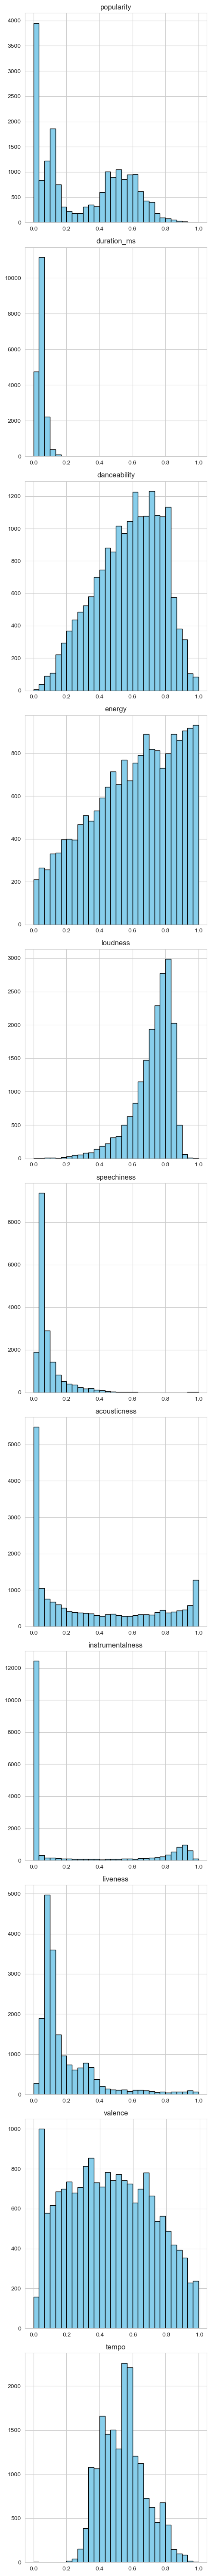

In [219]:
import matplotlib.pyplot as plt
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Plotting histograms for each numeric column
fig, ax = plt.subplots(len(df_numeric.columns), 1, figsize=(5, 60))

for i, column in enumerate(df_numeric.columns):
    ax[i].hist(df_numeric[column], bins=30, color='skyblue', edgecolor='black')
    ax[i].set_title(column)

plt.tight_layout()
plt.show()

In [220]:
df.shape

(18732, 28)

# Dimensional Reduction (UMAP)

C:\Users\brand\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


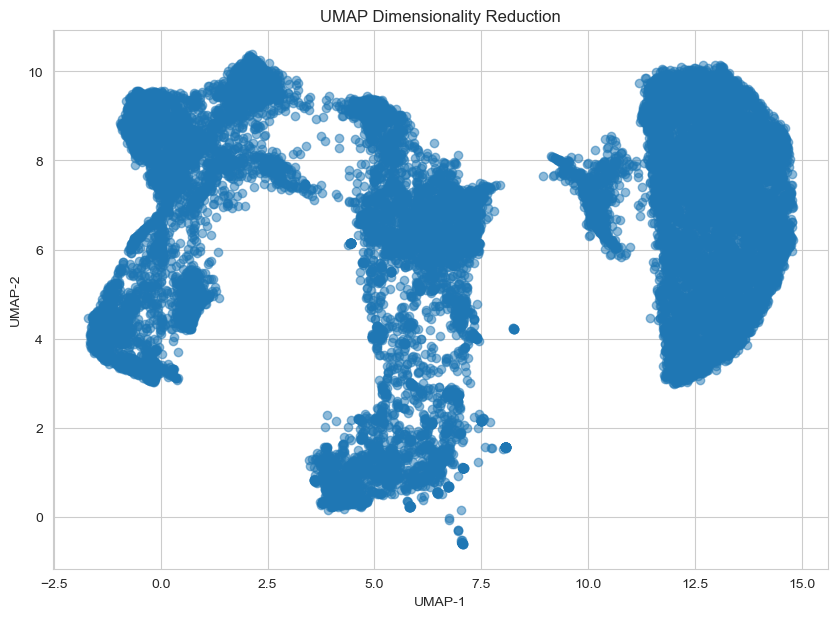

In [222]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Selecting only numeric columns (assuming your DataFrame is named as 'df')
numeric_columns = df.select_dtypes(include=[np.number]).columns
data_for_umap = df[numeric_columns]

# Initialize UMAP. You can adjust n_neighbors and min_dist based on your data characteristics
umap_model = umap.UMAP(random_state = 99, min_dist = 0.1, n_neighbors = 100)

# Fit the model and transform your data to 2 dimensions
umap_data = umap_model.fit_transform(data_for_umap)

# Plotting the results
plt.figure(figsize=(10, 7))
plt.scatter(umap_data[:, 0], umap_data[:, 1], alpha=0.5)
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

In [104]:
umap_data.shape

(18732, 2)

## Dimensionality Reduction (PCA)

In [105]:
# PCA for dimensionality reduction

pca = PCA(n_components=2) # Adjust n_components based on your dataset, .95 leads to 53 features
pca_data = pca.fit_transform(df)
pca_data.shape

(18732, 2)

In [106]:
umap_data

array([[12.939385 ,  8.974014 ],
       [12.265543 ,  9.189985 ],
       [12.236198 ,  8.888993 ],
       ...,
       [14.711024 ,  7.149636 ],
       [14.549725 ,  7.4543405],
       [14.619803 ,  7.9762106]], dtype=float32)

In [107]:
pca_data

array([[-0.71907891,  0.37304122],
       [-0.22593185, -0.57939624],
       [-0.33371095, -0.61735235],
       ...,
       [-0.6299697 ,  0.2835282 ],
       [-0.24894916, -0.60659423],
       [-0.3586623 , -0.48404311]])

## Clustering (KMM)
elbow method

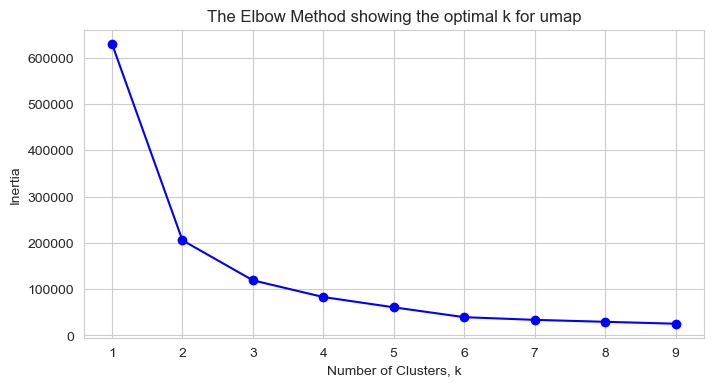

In [225]:
inertia = []
K = range(1, 10)  # Adjust the range of k as needed

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_data)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k for umap')
plt.show()


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

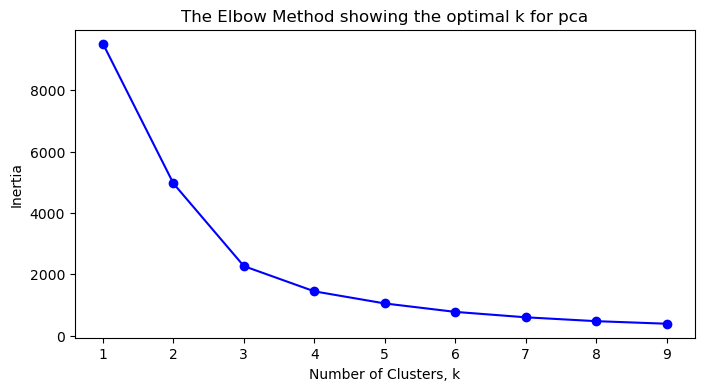

In [109]:
inertia = []
K = range(1, 10)  # Adjust the range of k as needed

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k for pca')
plt.show()

In [223]:
kmeans = KMeans(n_clusters=3, random_state=42) # Adjust n_clusters based on your needs
clusters_umap = kmeans.fit_predict(umap_data)

#Evaluate silhouette score
silhouette_avg = silhouette_score(umap_data, clusters_umap)

print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.56


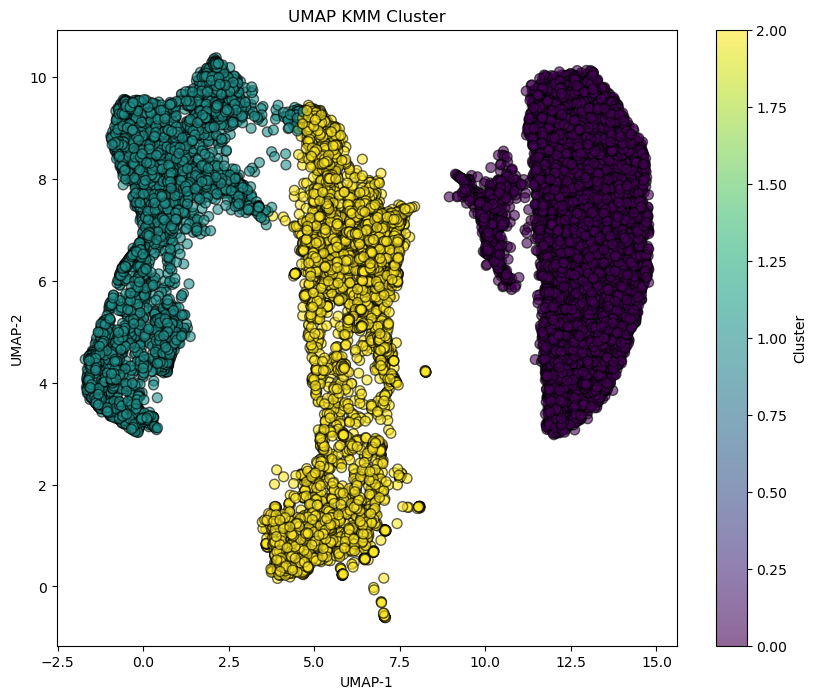

In [111]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=clusters_umap, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title('UMAP KMM Cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar(label='Cluster')
plt.show()

In [228]:
kmeans = KMeans(n_clusters=2, random_state=42) # Adjust n_clusters based on your needs
clusters_pca = kmeans.fit_predict(pca_data)

#Evaluate silhouette score
silhouette_avg = silhouette_score(pca_data, clusters_pca)

print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.55


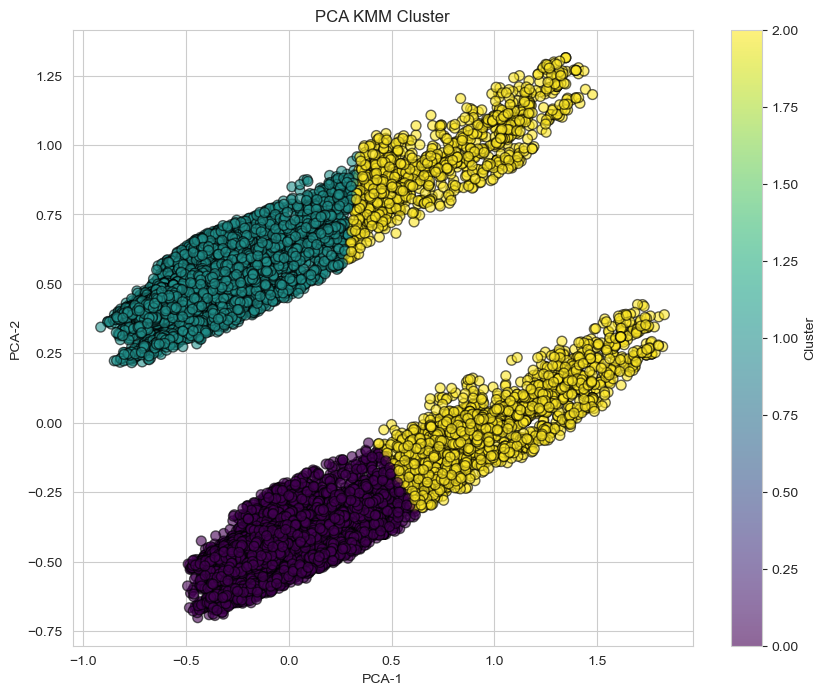

In [227]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters_pca, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title('PCA KMM Cluster')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.colorbar(label='Cluster')
plt.show()

## Data Analysis

from sklearn.cluster import SpectralClustering

spect = SpectralClustering(n_clusters = 3).fit(pca_data)
cluster_labels = spect.fit_predict(pca_data)
plt.figure(figsize=(8, 6))
plt.scatter(ucs[:, 0], ucs[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Spectral Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

In [149]:
df = df0.assign(clusters_pca=clusters_pca)
df = df.assign(clusters_umap=clusters_umap)
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,clusters_pca,clusters_umap
5000,5000,1gUAX2ImxDsB3YDcyxMXlB,美波,カワキヲアメク,カワキヲアメク,71,251933,False,0.541,0.846,6,-2.729,0,0.0551,0.01220,0.000149,0.1630,0.524,129.138,4,anime,1,0
5001,5001,1di1C0QI6Y92yZPYn6XYAZ,KANA-BOON,TIME,シルエット,73,240133,False,0.436,0.934,2,-2.685,1,0.0507,0.00001,0.140000,0.3210,0.384,91.481,4,anime,0,0
5002,5002,3khEEPRyBeOUabbmOPJzAG,Kenshi Yonezu,KICK BACK,KICK BACK,83,193495,False,0.577,0.941,1,-5.170,1,0.1050,0.00207,0.000003,0.0891,0.292,101.921,4,anime,0,0
5003,5003,1rN9QoVxw5U7TJkyaUR8C1,TK from Ling tosite sigure,Fantastic Magic,unravel,73,238360,False,0.508,0.889,7,-2.755,0,0.0862,0.04950,0.000000,0.0984,0.332,135.014,4,anime,1,0
5004,5004,23phSRwoMy48rwFpmuAP8q,Yoko Takahashi,残酷な天使のテーゼ/魂のルフラン,残酷な天使のテーゼ,60,247746,False,0.691,0.773,0,-5.244,0,0.0494,0.01740,0.000451,0.1170,0.502,128.162,4,anime,1,0


# How does our 3 clusters correlate with genres?


In [150]:
genre_cluster_distribution = df.groupby(['track_genre', 'clusters_umap']).size().unstack(fill_value=0)
genre_cluster_distribution['sum'] = genre_cluster_distribution.sum(axis=1)
genre_cluster_distribution_percentage = genre_cluster_distribution[[0, 1, 2]].div(genre_cluster_distribution['sum'], axis=0).round(2)

# Display the result
genre_cluster_distribution_percentage

clusters_umap,0,1,2
track_genre,,,
anime,0.67,0.31,0.02
chicago-house,0.04,0.63,0.33
chill,0.75,0.20,0.05
classical,0.16,0.68,0.15
detroit-techno,0.02,0.84,0.14
emo,0.89,0.04,0.07
grindcore,0.03,0.69,0.28
grunge,0.88,0.04,0.07
idm,0.04,0.80,0.16


In [152]:
cluster0 = genre_cluster_distribution_percentage[0]
cluster1 = genre_cluster_distribution_percentage[1]
cluster2 = genre_cluster_distribution_percentage[2]

print('cluster 0\'s genres',cluster0.sort_values(ascending=False))
print('cluster 1\'s genres',cluster1.sort_values(ascending=False))
print('cluster 2\'s genres',cluster2.sort_values(ascending=False))

cluster 0's genres track_genre
sertanejo         1.00
pop-film          0.97
k-pop             0.94
indian            0.93
sad               0.89
emo               0.89
grunge            0.88
chill             0.75
anime             0.67
pop               0.59
jazz              0.22
classical         0.16
latin             0.11
kids              0.10
idm               0.04
chicago-house     0.04
grindcore         0.03
romance           0.03
detroit-techno    0.02
iranian           0.00
Name: 0, dtype: float64
cluster 1's genres track_genre
detroit-techno    0.84
idm               0.80
iranian           0.69
grindcore         0.69
classical         0.68
chicago-house     0.63
anime             0.31
chill             0.20
jazz              0.09
sad               0.08
grunge            0.04
emo               0.04
indian            0.04
romance           0.04
kids              0.02
k-pop             0.01
latin             0.01
pop               0.01
pop-film          0.01
sertanejo        

In [154]:

df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'clusters_pca', 'clusters_umap'],
      dtype='object')

In [158]:
df.popularity.value_counts()

popularity
0      3247
11      498
12      480
10      470
8       451
       ... 
98        2
97        2
95        2
94        2
100       1
Name: count, Length: 100, dtype: int64

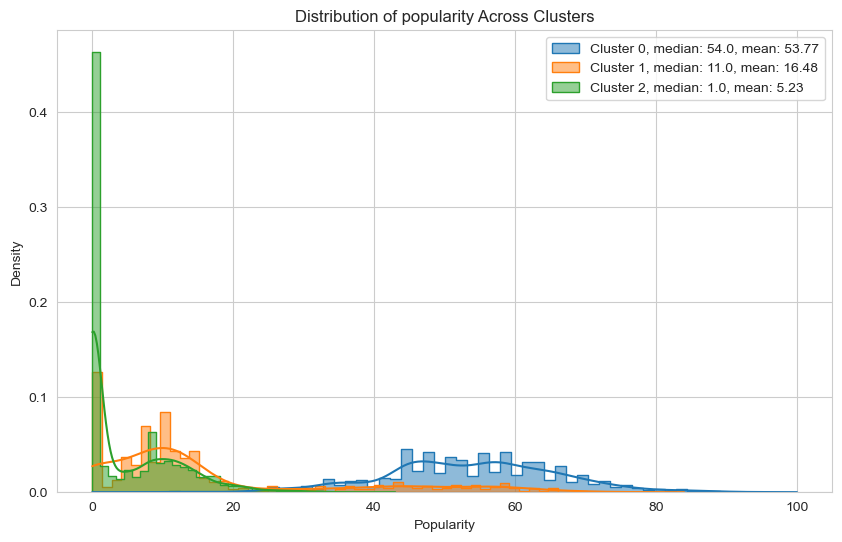

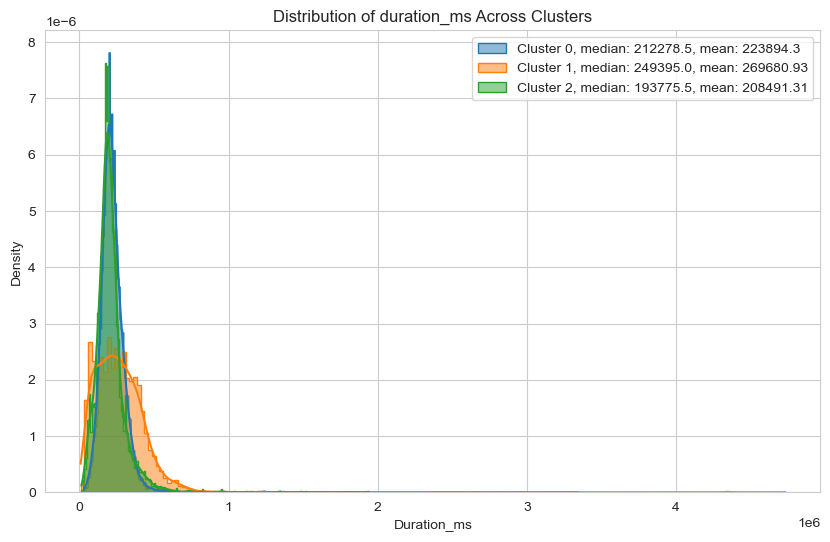

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


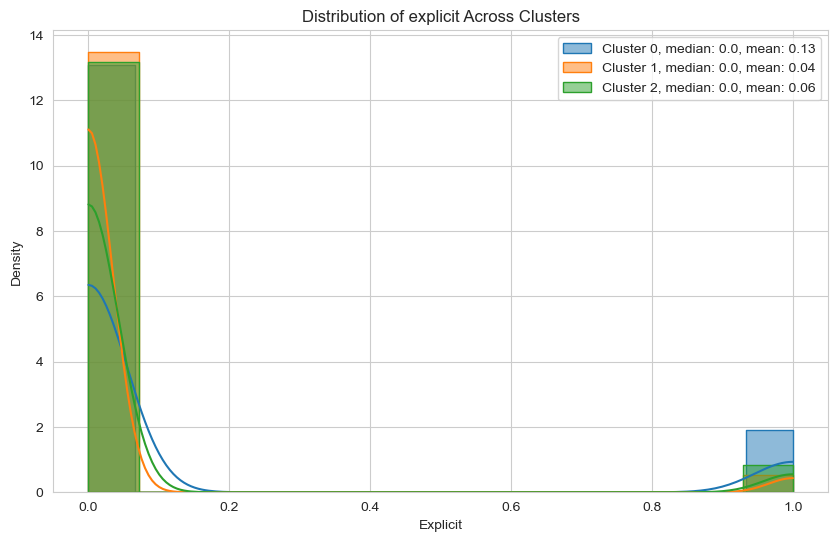

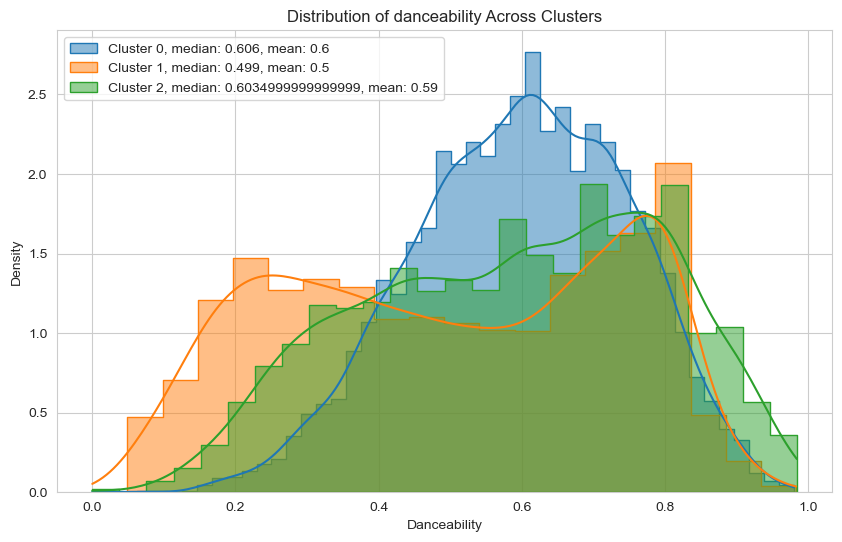

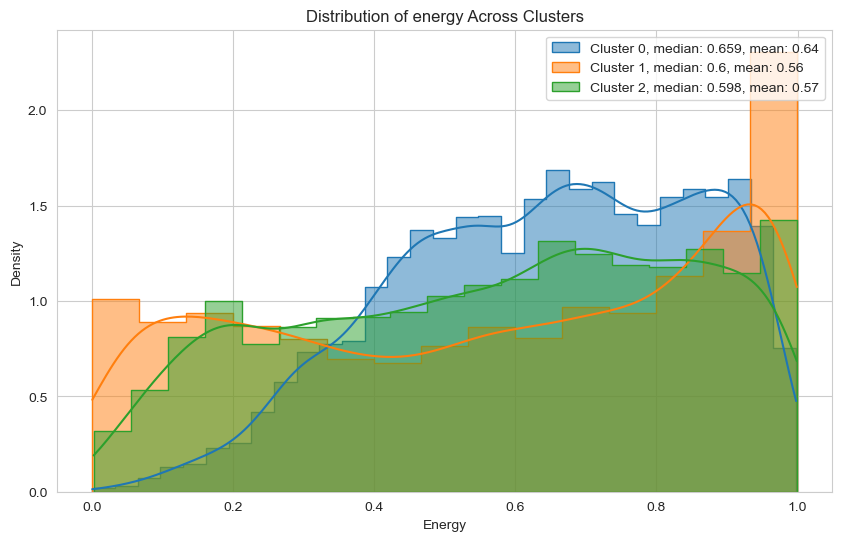

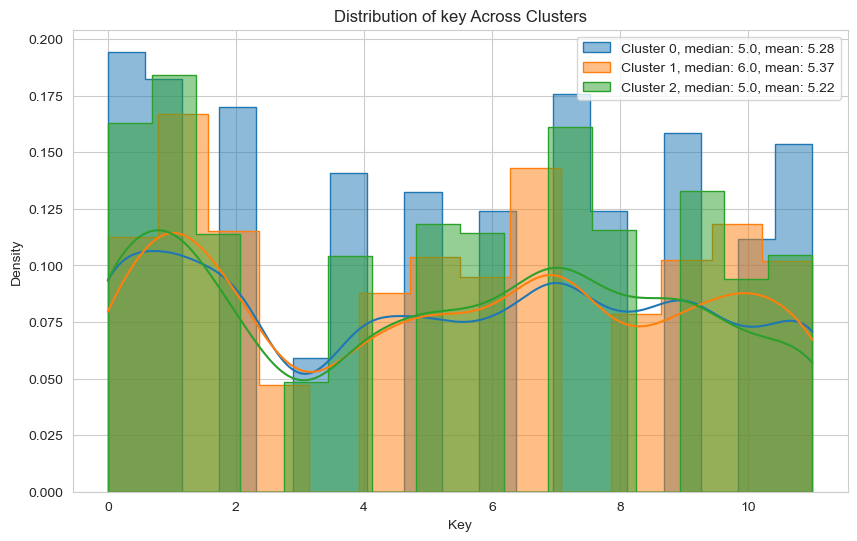

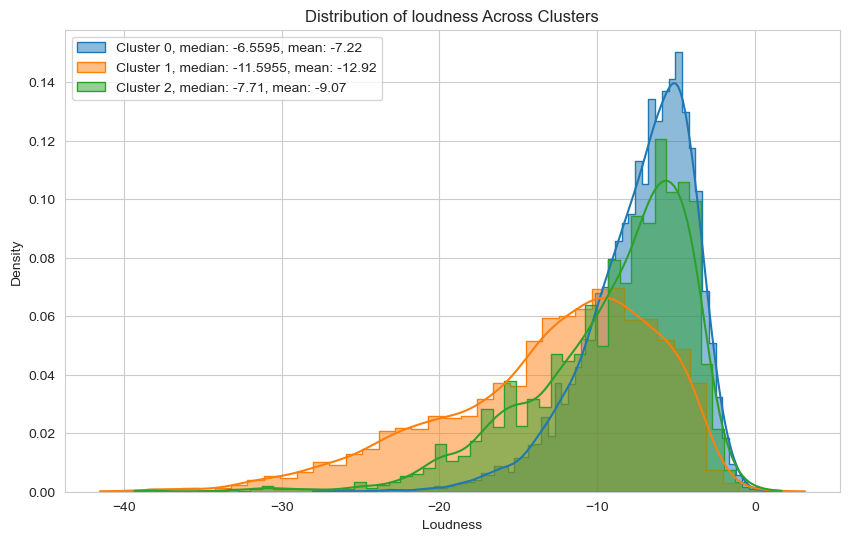

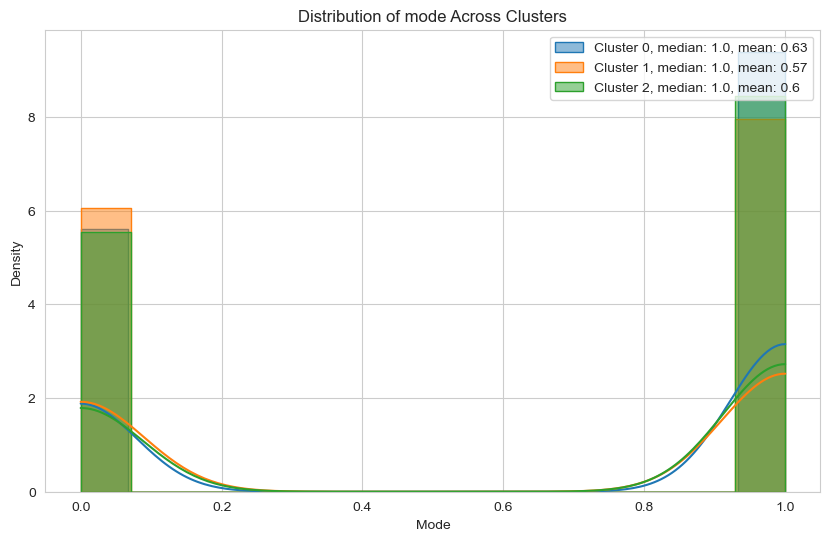

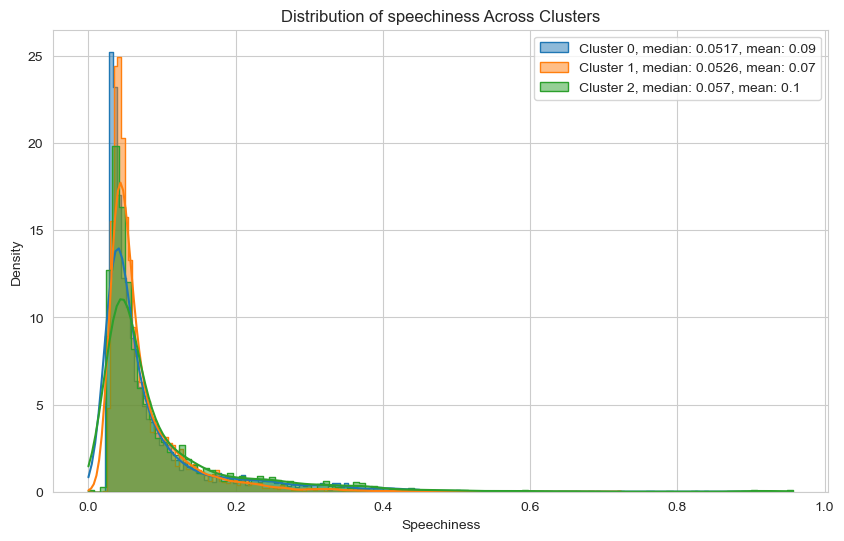

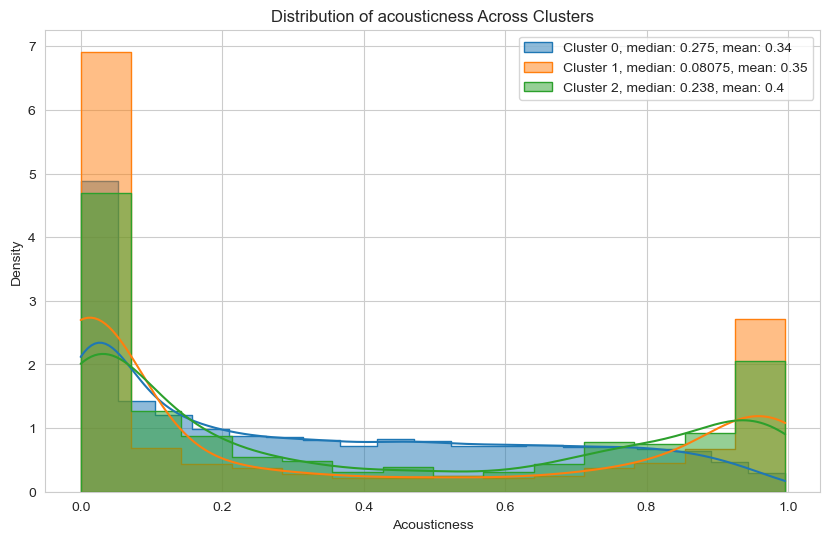

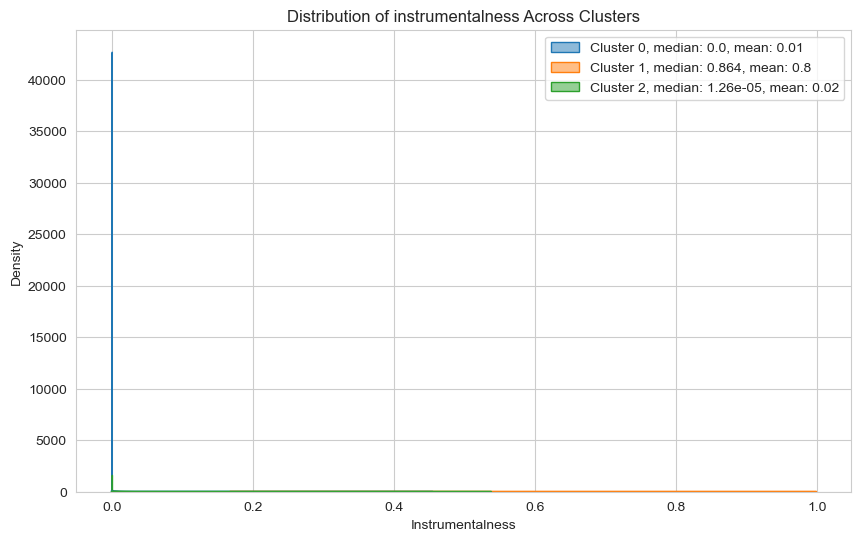

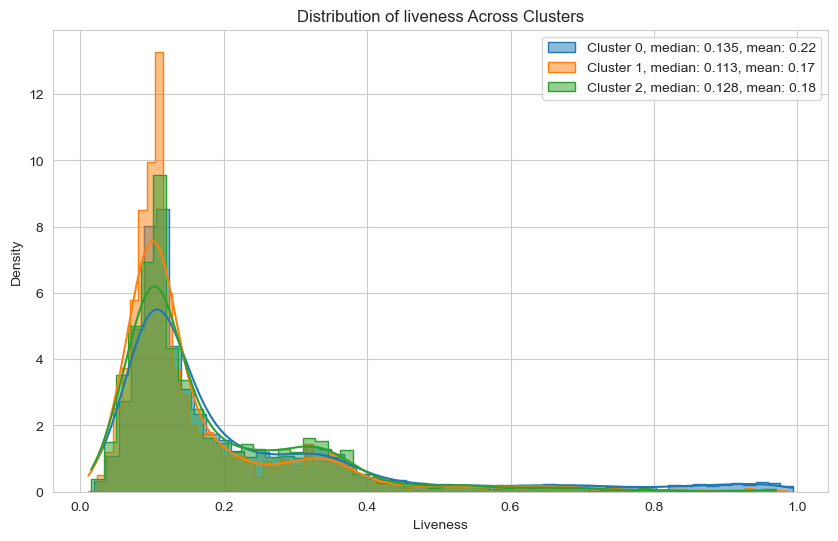

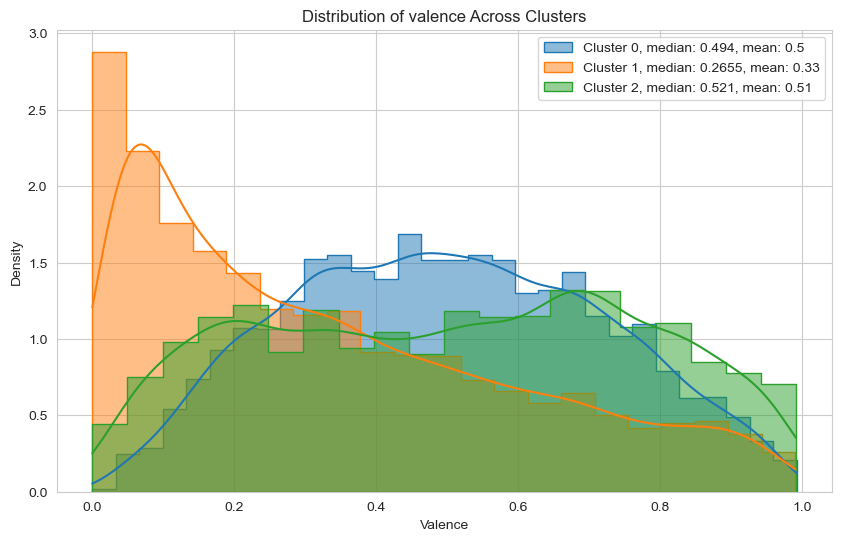

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['popularity', 'duration_ms', 'explicit','danceability', 'energy', 'key','loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

sns.set_style('whitegrid')

for feature in features:
    plt.figure(figsize=(10, 6))
    median_group = df.groupby('clusters_umap')[feature].median()
    mean_group = df.groupby('clusters_umap')[feature].mean()
    for cluster in df['clusters_umap'].unique():
        median = median_group[cluster]
        mean = mean_group[cluster].round(2)

        # Selecting data for the current cluster
        cluster_data = df[df['clusters_umap'] == cluster][feature]
        sns.histplot(cluster_data, label=f'Cluster {cluster}, median: {median}, mean: {mean}', kde=True, element='step', stat='density', common_norm=False)
    
    plt.title(f'Distribution of {feature} Across Clusters')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Grid Search

In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Assume `data` is your input features
data = processed_data

# Define the range of parameters you want to search
pca_components = [2, 4, 8]
n_clusters = [2, 5, 10, 50]

best_score = -1
best_params = {'n_components': None, 'n_clusters': None}

for components in pca_components:
    pca = PCA(n_components=components)
    reduced_data = pca.fit_transform(data)
    for clusters in n_clusters:
        kmeans = KMeans(n_clusters=clusters, random_state=42)
        labels = kmeans.fit_predict(reduced_data)
        score = silhouette_score(reduced_data, labels)
        print(score)
        
        if score > best_score:
            best_score = score
            best_params['n_components'] = components
            best_params['n_clusters'] = clusters

print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.46013842865557747


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3436894510020834


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.32075957062979127


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.32014316850641167


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.32961436619986323


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.2411026705904736


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.2183410456861364


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.18846588588542376


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.24356538630569546


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.15909506459937267


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.17221804564039325


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.12773901920407993
Best Silhouette Score: 0.46013842865557747
Best Parameters: {'n_components': 2, 'n_clusters': 2}


In [28]:
scores = [.46, .34, .32, .32, .33, .24, .22, .19, .24, .16, .17, .12]

In [30]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Assume `data` is your input features
data = processed_data

# Define the range of parameters you want to search
pca_components = [.95]
n_clusters = [2, 5, 10, 50]

best_score = -1
best_params = {'n_components': None, 'n_clusters': None}

for components in pca_components:
    pca = PCA(n_components=components)
    reduced_data = pca.fit_transform(data)
    for clusters in n_clusters:
        kmeans = KMeans(n_clusters=clusters, random_state=42)
        labels = kmeans.fit_predict(reduced_data)
        score = silhouette_score(reduced_data, labels)
        print(score)
        
        if score > best_score:
            best_score = score
            best_params['n_components'] = components
            best_params['n_clusters'] = clusters

print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)

C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.21860414910686907


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.13522039513176556


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.13297789198782498


C:\Users\brand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.09780074803953527
Best Silhouette Score: 0.21860414910686907
Best Parameters: {'n_components': 0.95, 'n_clusters': 2}


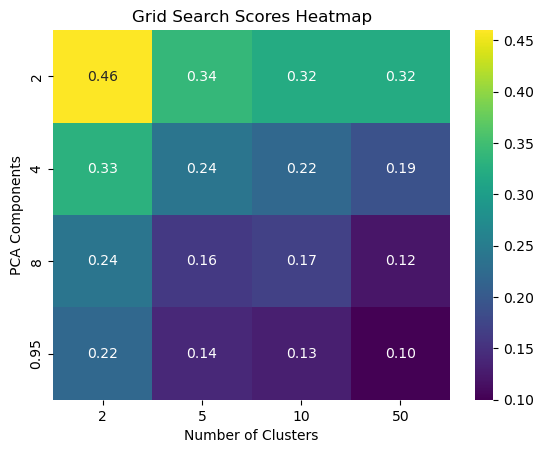

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#grid search results
pca_components = [2, 4, 8, .95]
n_clusters = [2, 5, 10, 50]
scores = [.46, .34, .32, .32, .33, .24, .22, .19, .24, .16, .17, .12, .22, .14, .13, .10]

# Reshaping
scores_matrix = np.array(scores).reshape(len(pca_components), len(n_clusters))

# Creating a heatmap
sns.heatmap(scores_matrix, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=n_clusters, yticklabels=pca_components)

plt.title("Grid Search Scores Heatmap")
plt.xlabel("Number of Clusters")
plt.ylabel("PCA Components")
plt.show()


Best is actually 2 PCA with 5 Clusters

In [208]:
from sklearn.datasets import load_digits
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Load example data
data_for_umapn = df.copy()
# Define the parameter grid
param_grid = {
    'n_neighbors': [2, 20, 200],
    'n_components': [2],
    'min_distance': [0.1, 0.5],
    'n_clusters':[3, 7, 20]
}

# Placeholder for best parameters and their score
best_params = None
best_score = -np.inf

# Grid search
for n_neighbors in param_grid['n_neighbors']:
    for n_components in param_grid['n_components']:
        for min_distance in param_grid['min_distance']:
            # Configure UMAP with the current set of parameters
            umap_model = umap.UMAP(random_state = 99, min_dist = 0.1, n_neighbors = 300)

            # Fit the model and transform your data to 2 dimensions
            umap_data = umap_model.fit_transform(data_for_umap)
            
            # Evaluate the embedding, here using the silhouette score as an example
            score = silhouette_score(umap_embedding, umap_data)
            
            # Update best parameters if current score is better
            if score > best_score:
                best_score = score
                best_params = {
                    'n_neighbors': n_neighbors,
                    'n_components': n_components,
                    'min_distance': min_distance,
                }

print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")



C:\Users\brand\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


NameError: name 'umap_embedding' is not defined

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Selecting only numeric columns (assuming your DataFrame is named as 'df')
numeric_columns = df.select_dtypes(include=[np.number]).columns
#data_for_umap = df[numeric_columns]
data_for_umap = df[music_features]

# Initialize UMAP. You can adjust n_neighbors and min_dist based on your data characteristics
umap_model = umap.UMAP(random_state = 99, min_dist = 0.1, n_neighbors = 300)

# Fit the model and transform your data to 2 dimensions
umap_data = umap_model.fit_transform(data_for_umap)

# Plotting the results
plt.figure(figsize=(10, 7))
plt.scatter(umap_data[:, 0], umap_data[:, 1], alpha=0.5)
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42) # Adjust n_clusters based on your needs
clusters_umap = kmeans.fit_predict(umap_data)

#Evaluate silhouette score
silhouette_avg = silhouette_score(umap_data, clusters_umap)

print(f'Silhouette Score: {silhouette_avg:.2f}')